# 02: Quantum Information Processing in QuTiP II

In the previous tutorial, we looked at how to create and run circuits. In this tutorial we'll look at how circuits are implemented on real quantum devices and how we can use QuTiP to simulate the *quantum hardware* itself.

Quite a few steps are needed to translate a quantum circuit into actions for robots to perform on the real apparatus:

1. Optimize the assignment of qubits to the device.
2. Add swap gates to allow operations between device qubits that cannot directly interact.
3. Replace the circuit gates with gates the device can perform.
4. Translate the gates into control pulses for the device.
5. Send the pulses to the device.

The steps above are just one example of a translation process. The details will vary between different kinds of quantum hardware. In a neutral atom device, one would choose how to layout the neutral atoms for the circuit. The pulses themselves will need to be optimized for the circuit. Some pulses will be performed simultaneously. Others will need to be performed one after the other. Pulses and gates could be combined. Extra pulses might be added to perform dynamic decoupling.

QuTiP's QIP module provides the means to perform all of the steps above and to run the resulting pulses on a *simulated* hardware device.

A simulated hardware device is a time-dependented Hamiltonian (or Liouvillian) that describes the physics of the system (e.g. interactions between atoms or qubits) and the actions of the control pulses. Typically the control pulses define the time-dependent amplitude of an oscillating term in the Hamiltonian.

Let's try all the steps out in QuTiP.

## Tasks

- [Import qutip and qutip.qip](#imports)
- [Spin chain qubits](#spin-chain-qubits)
- [Create a simple circuit to translate](#create-a-simple-circuit-to-translate)
- [Add swap gates by hand](#add-swap-gates-by-hand)
- [Add swap gates automatically](#add-swap-gates-automatically)
- [Translate to native gates](#translate-to-native-gates)
- [Turn gates into pulses](#turn-gates-into-pulses)
- [Run the pulses on the device](#run-the-pulses-on-the-device)

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import qutip
from qutip_qip.circuit import QubitCircuit
from qutip_qip.device import LinearSpinChain
import numpy as np
import re

In [3]:
orig_latex_code = QubitCircuit.latex_code

def fix_swap(self):
    tex = orig_latex_code(self)
    tex = re.sub(r"( \\qwx\[)(\d+)(\] )", r"\1-\2\3", tex)
    return tex

QubitCircuit.latex_code = fix_swap

## Linear spin chain qubits

Before we begin, we need to pick what kind of hardware device we will translate to. We'll choose a linear spin chain with three qubits:

![02-spin-chain.png](./02-spin-chain.png)

The nodes are the three qubits. The lines are the interactions between them. Note that each qubit can only interact with the two next to it in the chain. Qubits 0 and 2 cannot interact directly.

Each qubit can be controlled by rotations around the $X$ and $Z$ axis. The corresponding Hamiltonian for qubit $j$ is:

$$
    \Omega^x_{j}(t) \sigma^x_{j} + \Omega^z_{j}(t) \sigma^z_{j}
$$

$ \Omega^x_{j}(t) $ and $ \Omega^z_{j}(t) $ are coefficients that are functions of time and which we can control in the real device by, e.g., firing a microwave pulse towards qubit $j$.

The interactive between qubits $j$ and $j + 1$ is described by the Hamiltonian:
    
$$
    g_{j}(t) (\sigma^x_{j}\sigma^x_{j+1} + \sigma^y_{j}\sigma^y_{j+1})
$$

Where here $g_{j}(t)$ is the time-dependent coefficient function that we can use to control the interaction.

Putting all Hamiltonians for all of the qubits and interaction together, we get the full Hamiltonian for the system:

$$
H = \sum_{j=0}^{N-1}
        \Omega^x_{j}(t) \sigma^x_{j} +
        \Omega^z_{j}(t) \sigma^z_{j} +
    \sum_{j=0}^{N-2}
        g_{j}(t)
        (\sigma^x_{j}\sigma^x_{j+1}+
        \sigma^y_{j}\sigma^y_{j+1})
$$

Don't worry about understanding the Hamiltonian fully. The point is to have a general model of how a linear spin chain interacts and can be controlled that you keep in your head during the rest of this tutorial.

QuTiP has a prebuilt version of this model. You can great an instance of it with:

In [4]:
processor = LinearSpinChain(3)

## Create a simple circuit to translate

Create this simple circuit to translate:

![02-circuit.png](./02-circuit.png)

It doesn't perform any specific useful operation. It's just a very simple example that will allow us to focus on what is happening during translation rather than what the circuit does.

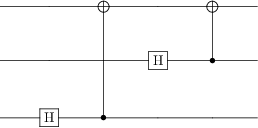

In [5]:
qc = QubitCircuit(N=3)

qc.add_gate("SNOT", targets=0)
qc.add_gate("CNOT", targets=2, controls=0)

qc.add_gate("SNOT", targets=1)
qc.add_gate("CNOT", targets=2, controls=1)

qc

## Add swap gates by hand

The circuit above can't be implemened directly on the device because the first CNOT operates on qubits 0 and 2 which are not next to each other in the spin chain and so can't interact.

By hand, add some swap gates around the first CNOT gate so that the result circuit performs the same operation but could be executed on our spin chain.

Could you have added different swap gates? Can you think of some reasons why some choices might be better than others? What about in bigger circuits with more gates?

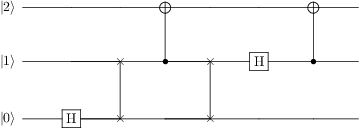

In [6]:
qc_swap = QubitCircuit(N=3, input_states=["0", "1", "2"])

qc_swap.add_gate("SNOT", targets=0)
qc_swap.add_gate("SWAP", targets=[0, 1])
qc_swap.add_gate("CNOT", targets=2, controls=1)
qc_swap.add_gate("SWAP", targets=[0, 1])

qc_swap.add_gate("SNOT", targets=1)
qc_swap.add_gate("CNOT", targets=2, controls=1)

qc_swap

## Add swap gates automatically

QuTiP's processors have a built-in method for performing the swaps -- `processor.topology_map(qc)`. It takes in a circuit and returns a new circuit with the swaps added.

It has a small bug that means we have to fix the labels for the input states afterwards by doing `qc_swapped.input_states = qc.input_states`. If you are feeling adventurous later this week, we'd love a pull request to fix this bug. The issue is described in more detail at https://github.com/qutip/qutip-qip/issues/165.

Compare the resulting circuit below to the swaps you used.

Spend some time thinking about how you might write a general algorithm like this which can apply the appropriate swaps to *any* circuit. How would you make such an algorithm optimal? What does optimal mean for this problem? Would it help to be able to reorder the qubits at the start?

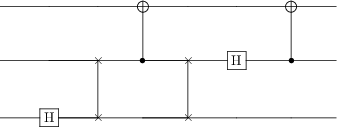

In [7]:
qc_auto_swap = processor.topology_map(qc)
qc_auto_swap.input_states = qc.input_states
qc_auto_swap

## Translate to native gates

Now that we have the swaps in place, the next step is to translate the gates our device can implement -- i.e. ones that can be turned into control pulses to send to our spin chain device.

You can list the native gates for the device using:
```
processor.native_gates
```

They are native single qubit gates are `RX` and `RZ`. They rotate the qubit around the `X` and `Z` axes. Each takes an angle to rotate through as a parameter. They are performed using the $\Omega^x_{j}(t)$ and $\Omega^z_{j}(t)$ pulses from the Hamiltonian.

The native two qubit gates are `ISWAP` and `SQRTISWAP`. They are performed using the interaction pulse $g_{j}(t)$ plus some additional control pulses on the individual qubits involved.

Use `processor.transpile(qc)` to transform the gates into native gates. Whoa! It's complicated. Try to figure out what sequence of gates each of the individual gates was translated too. Use `.transpile` on simpler circuits with just one gate if you get stuck or to check your findings.

What are the strange giant $Ph(\pi /2)$ gates? How are they implemented?

In [8]:
processor.native_gates

['SQRTISWAP', 'ISWAP', 'RX', 'RZ']

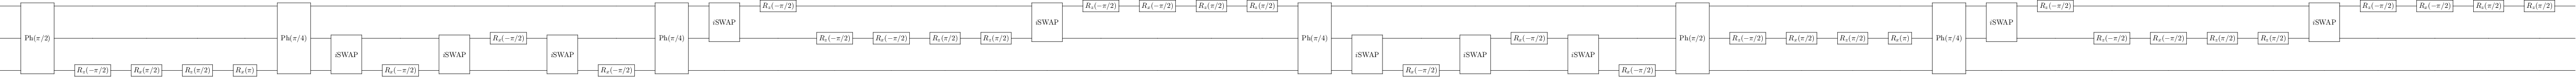

In [9]:
qc_native = processor.transpile(qc)
qc_native

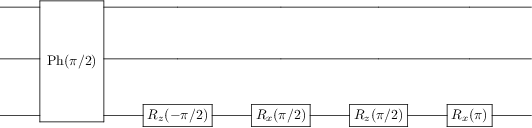

In [10]:
qc_snot = QubitCircuit(N=3)
qc_snot.add_gate("SNOT", targets=0)
processor.transpile(qc_snot)

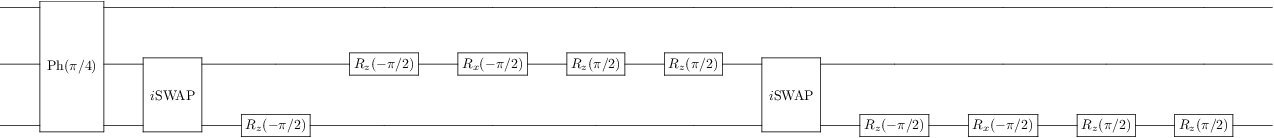

In [11]:
qc_cnot = QubitCircuit(N=3)
qc_cnot.add_gate("CNOT", targets=0, controls=1)
processor.transpile(qc_cnot)

## Turn gates into pulses

The compiled coefficients are square pulses and the control coefficients on 𝜎𝑧 and 𝜎𝑥 are also different, resulting in different gate times.

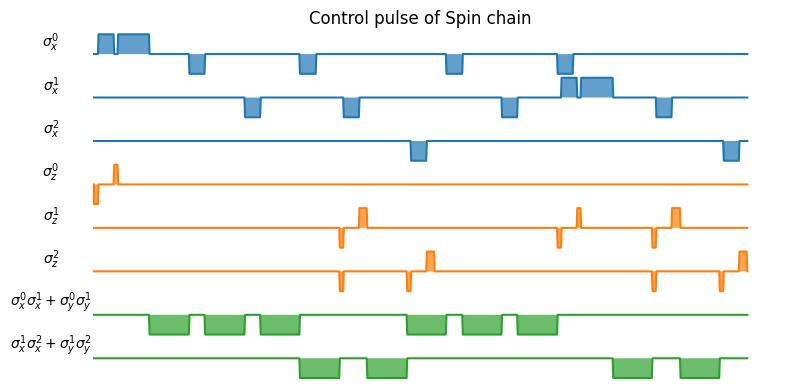

In [12]:
processor.load_circuit(qc)
processor.plot_pulses(title="Control pulse of Spin chain", figsize=(8, 4), dpi=100);

## Run the pulses on the device

QuTiP's processor provides a method `.run_state(...)` for executing the pulses. Under the hood, this runs one of the QuTiP solvers, typically either `sesolve` or `mesolve`, and returns the result.

Use `run_state(init_state=psi0)` to determine the effect of the pulses on `psi0`. What do the dimensions of `psi0` have to be? Do the results match what you expect? Try a few different values for `psi0`.

By setting the decoherence times `t1` and `t2` on the processor using:
```
processor.t1 = 100
processor.t2 = 30
```
we can simulate the loss of information to the environment on the circuit.

If we add decoherence, what happens to the outcomes?

In [13]:
processor.t1 = None
processor.t2 = None

psi0 = qutip.basis([2, 2, 2], [0,0,0])
proj0 = qutip.ket("0").proj()
proj1 = qutip.ket("1").proj()

result = processor.run_state(init_state=psi0)
print("Probability of measuring qubit 0 in state 0:", qutip.expect(proj0, result.states[-1].ptrace(0)))
print("Probability of measuring qubit 0 in state 1:", qutip.expect(proj1, result.states[-1].ptrace(0)))

Probability of measuring qubit 0 in state 0: 0.49998981210581084
Probability of measuring qubit 0 in state 1: 0.5000101878941888


In [14]:
processor.t1 = 100
processor.t2 = 30

result = processor.run_state(init_state=psi0)
print("Probability of measuring qubit 0 in state 0:", qutip.expect(proj0, result.states[-1].ptrace(0)))
print("Probability of measuring qubit 0 in state 1:", qutip.expect(proj1, result.states[-1].ptrace(0)))

Probability of measuring qubit 0 in state 0: 0.5816168440850089
Probability of measuring qubit 0 in state 1: 0.4183831559149921


## Links for further study

Boxi Li wrote an excellent example of simulating the entire Deutsch-Jozsa algorithm on a spin chain in QuTiP. You can find it with the other QuTiP tutorials at [qutip.org](https://qutip.org/tutorials.html) under the title *Simulating the Deutsch–Jozsa algorithm with noise*.